# Build Trees from Action Sequence Data

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import matplotlib.image as mpimg

# Function Definitions
def generate_unique_sequences(actions):
    """
    Generate all unique sequences of actions.
    Parameters:
    - actions: list of actions (strings).

    Returns:
    - Counter object with unique action sequences as keys and their counts as values.
    """
    sequence_counter = Counter()
    for n in range(1, len(actions) + 1):
        n_grams = zip(*[actions[i:] for i in range(n)])
        sequence_counter.update(set(n_grams))
    return sequence_counter

def filter_subsequences(sequence_counter):
    """
    Filter out subsequences that are part of a longer sequence from a sequence counter.

    Parameters:
    - sequence_counter: Counter object with sequences as keys and counts as values.

    Returns:
    - Counter object with filtered sequences.
    """
    sequences = list(sequence_counter.items())
    sequences.sort(key=lambda x: (-len(x[0]), x))
    filtered_sequences = Counter()
    for i, (seq, count) in enumerate(sequences):
        if not any(all(item in longer_seq for item in seq) for longer_seq, _ in sequences[:i]):
            filtered_sequences[seq] = count
    return filtered_sequences

def sessionize_actions(df, threshold='30T'):
    """
    Sessionize actions based on a time threshold.

    Parameters:
    - df: DataFrame with at least 'timestamp' and 'user_id' columns.
    - threshold: string representing the time threshold for a new session.

    Returns:
    - DataFrame with an additional 'session_id' column.
    """
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df['time_diff'] = df.groupby('user_id')['timestamp'].diff()
    df['new_session'] = df['time_diff'] > pd.Timedelta(threshold)
    df['session_id'] = df.groupby('user_id')['new_session'].cumsum().fillna(0)
    return df

# Corrected function with proper defaultdict initialization
def add_sequence_to_tree(tree, sequence, count):
    """
    Add a sequence of actions to the tree data structure.

    Parameters:
    - tree: defaultdict representing the prefix tree.
    - sequence: tuple of action sequence.
    - count: integer representing the count of the sequence.

    Returns:
    - None, the tree is modified in place.
    """
    if sequence:
        try:
            first, rest = sequence[0], sequence[1:]
            if first not in tree:
                tree[first] = {'count': 0, 'next': defaultdict(lambda: {'count': 0, 'next': {}})}
            tree[first]['count'] += count
            if rest:
                add_sequence_to_tree(tree[first]['next'], rest, count)
        except KeyError as e:
            print(f"KeyError for sequence: {sequence}, missing key: {e}")
            raise
        
def calculate_probabilities(tree):
    """
    Calculate the probability of each node in the tree based on their count.

    Parameters:
    - tree: defaultdict representing the prefix tree with counts.

    Returns:
    - None, the tree is modified in place with a new 'prob' key for probability values.
    """
    total_count = sum(node['count'] for node in tree.values())
    for node in tree.values():
        node['prob'] = node['count'] / total_count if total_count > 0 else 0
        calculate_probabilities(node['next'])

def build_networkx_tree(graph, tree, parent=None, is_root=False):
    """
    Build a NetworkX tree from the given tree structure.

    Parameters:
    - graph: NetworkX graph object to which the nodes and edges will be added.
    - tree: defaultdict representing the prefix tree.
    - parent: the parent node's identifier.
    - is_root: boolean indicating if the current node is the root.

    Returns:
    - None, the graph is built in place.
    """
    if is_root and parent in tree:
        for node, node_data in tree[parent]['next'].items():
            child_name = f"{parent}-{node}"
            graph.add_node(child_name, label=node)
            graph.add_edge(parent, child_name, weight=node_data['count'], label=f"{node_data['prob']:.2f}")
            build_networkx_tree(graph, node_data['next'], child_name)
    else:
        for node, node_data in tree.items():
            graph_name = f"{parent}-{node}" if parent else node
            graph.add_node(graph_name, label=node)
            graph.add_edge(parent, graph_name, weight=node_data['count'], label=f"{node_data['prob']:.2f}")
            build_networkx_tree(graph, node_data['next'], graph_name)

def visualize_tree(tree_graph, start_action):
    """
    Visualize the tree graph using matplotlib.

    Parameters:
    - tree_graph: NetworkX DiGraph object representing the tree to visualize.
    - start_action: the action from which to start the visualization.

    Returns:
    - None, the visualization is displayed using matplotlib.
    """
    # tree_graph = nx.DiGraph()
    # build_networkx_tree(tree_graph, tree, start_action, is_root=True)
    pos = nx.kamada_kawai_layout(tree_graph)
    plt.figure(figsize=(24, 16))
    nx.draw(tree_graph, pos, with_labels=True, labels=nx.get_node_attributes(tree_graph, 'label'),
            node_color='lightblue', node_size=2000, edge_color='gray', linewidths=2, font_size=15)
    edge_labels = nx.get_edge_attributes(tree_graph, 'label')
    nx.draw_networkx_edge_labels(tree_graph, pos, edge_labels=edge_labels, font_color='red')
    plt.title(f"Action Tree for '{start_action}' with Branching Probabilities")
    plt.show()


In [43]:

# Data Processing
df_actions = pd.read_csv('df_actions.csv')
df_actions_sorted = df_actions[0:1000].sort_values(by=['user_id', 'timestamp'])
df_sequences = df_actions_sorted.groupby('user_id')['action'].apply(list).reset_index()
df_sequences['action_sequences'] = df_sequences['action'].apply(generate_unique_sequences)
df_sequences['filtered_action_sequences'] = df_sequences['action_sequences'].apply(filter_subsequences)
aggregate_sequences = Counter()
df_sequences['filtered_action_sequences'].apply(aggregate_sequences.update)
aggregate_sequences = sorted(aggregate_sequences.items(), key=lambda x: -x[1])

# Sessionization and Sequence Analysis
df_sessionized = sessionize_actions(df_actions_sorted)
df_session_sequences = df_sessionized.groupby(['user_id', 'session_id'])['action'].apply(list).reset_index()
df_session_sequences['action_sequences'] = df_session_sequences['action'].apply(generate_unique_sequences)
df_session_sequences['filtered_action_sequences'] = df_session_sequences['action_sequences'].apply(filter_subsequences)
session_aggregate_sequences = Counter()
df_session_sequences['filtered_action_sequences'].apply(session_aggregate_sequences.update)
session_aggregate_sequences = sorted(session_aggregate_sequences.items(), key=lambda x: -x[1])


In [44]:
df_actions.head()

,user_id,email,action,timestamp,cohort,cohort_period
0,0,micheal37@example.org,B,2023-10-20 15:44:40.052232,2023-10,0
1,0,micheal37@example.org,I,2023-10-20 15:45:40.052232,2023-10,0
2,0,micheal37@example.org,G,2023-10-20 15:52:40.052232,2023-10,0
3,0,micheal37@example.org,E,2023-10-20 15:56:40.052232,2023-10,0
4,0,micheal37@example.org,I,2023-10-20 16:00:40.052232,2023-10,0


In [47]:
df_session_sequences.head()

,user_id,session_id,action,action_sequences,filtered_action_sequences
0,0,0,"[B, I, G, I, C, E, F, I, I, J, A, I, A, I, I]","{('G',): 1, ('E',): 1, ('B',): 1, ('A',): 1, (...","{('B', 'I', 'G', 'I', 'C', 'E', 'F', 'I', 'I',..."
1,1,0,"[A, A, F, J, F, E, D, F, C, H, G, H, B, A, H, ...","{('G',): 1, ('E',): 1, ('B',): 1, ('D',): 1, (...","{('A', 'A', 'F', 'J', 'F', 'E', 'D', 'F', 'C',..."
2,2,0,"[A, A, H, I, G, G, I, A, G, J, H, J, J, I, A, ...","{('G',): 1, ('B',): 1, ('D',): 1, ('I',): 1, (...","{('A', 'A', 'H', 'I', 'G', 'G', 'I', 'A', 'G',..."
3,2,1,[J],"{('J',): 1}","{('J',): 1}"
4,3,0,"[A, D, F, F, I, E, F, F, C, B, C, J, I, H, D, ...","{('E',): 1, ('B',): 1, ('A',): 1, ('D',): 1, (...","{('A', 'D', 'F', 'F', 'I', 'E', 'F', 'F', 'C',..."


Action Tree for 'B' with Branching Probabilities


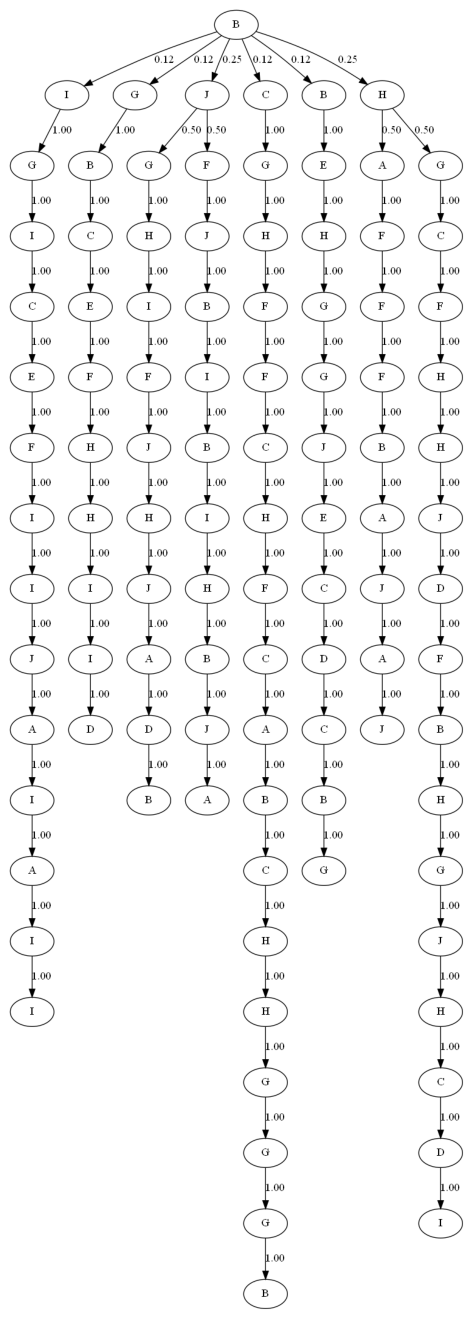

Action Tree for 'A' with Branching Probabilities


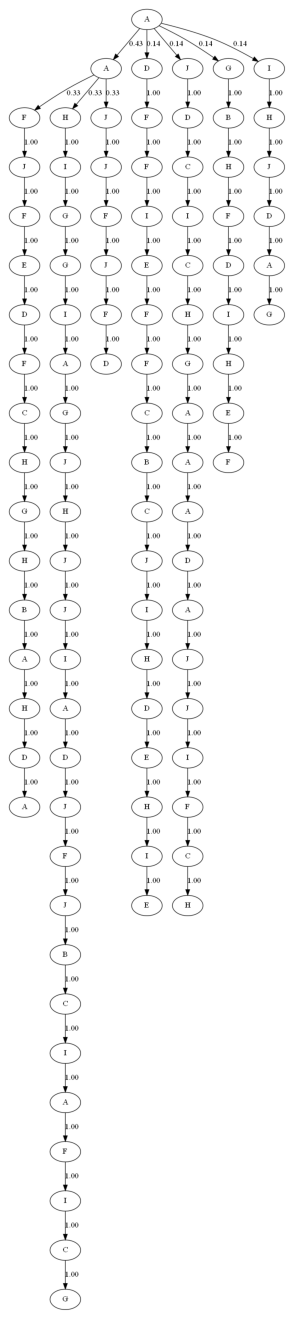

Action Tree for 'J' with Branching Probabilities


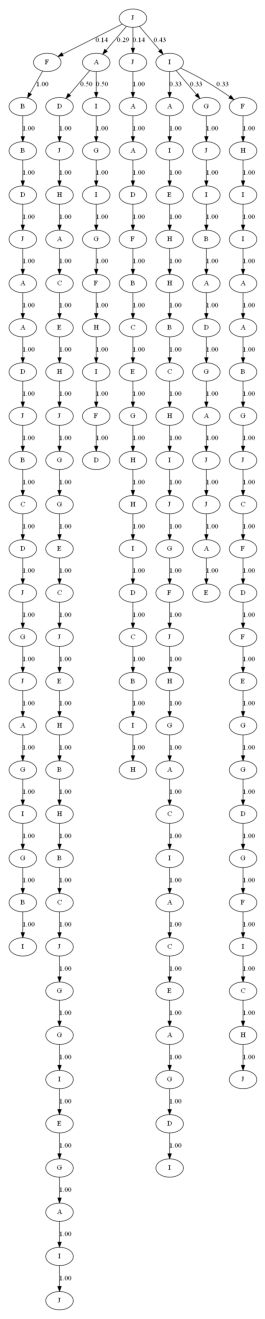

Action Tree for 'C' with Branching Probabilities


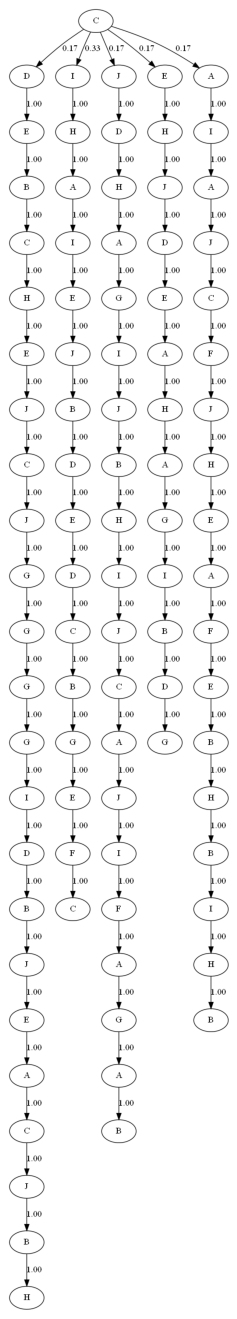

Action Tree for 'D' with Branching Probabilities


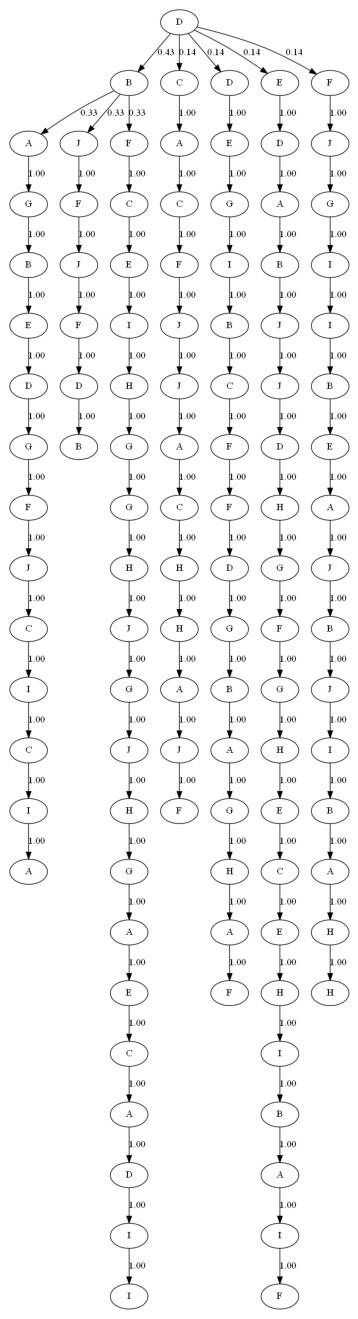

Action Tree for 'H' with Branching Probabilities


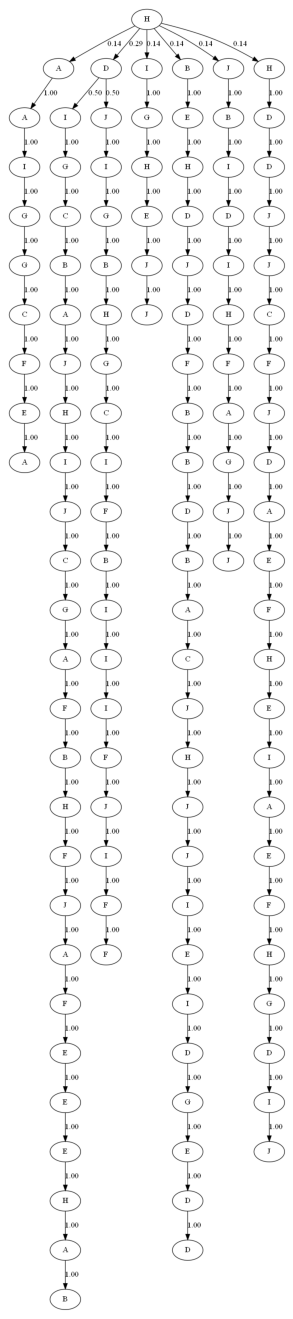

Action Tree for 'G' with Branching Probabilities


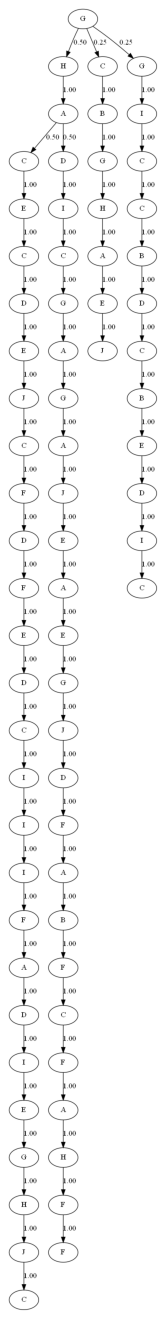

Action Tree for 'I' with Branching Probabilities


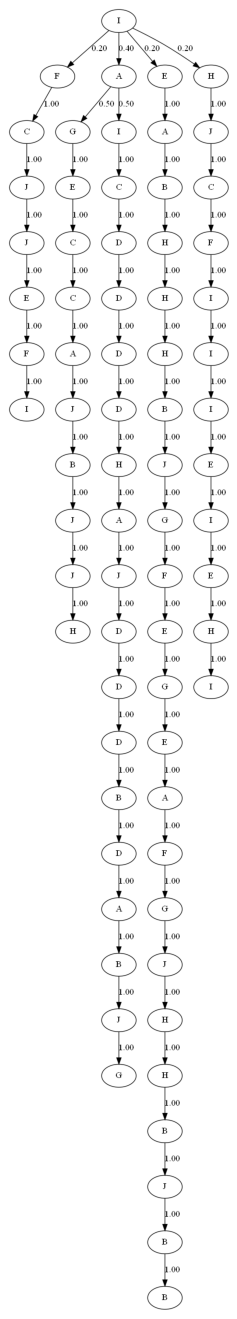

Action Tree for 'E' with Branching Probabilities


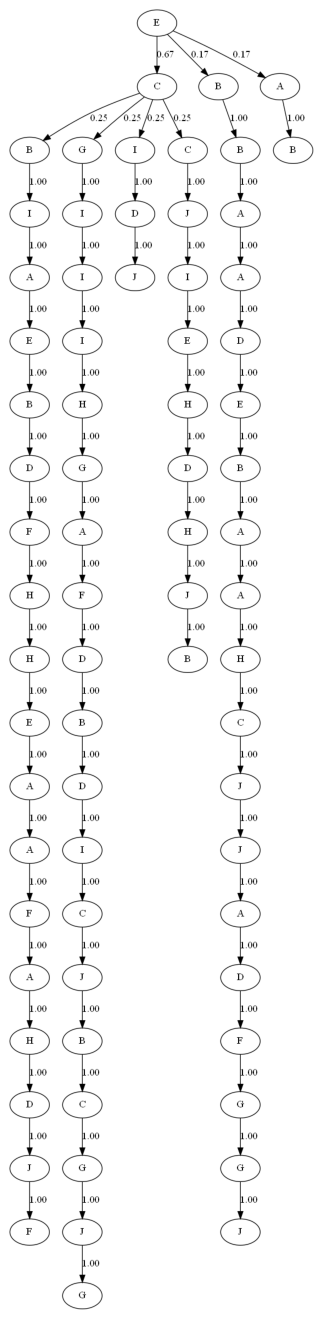

Action Tree for 'F' with Branching Probabilities


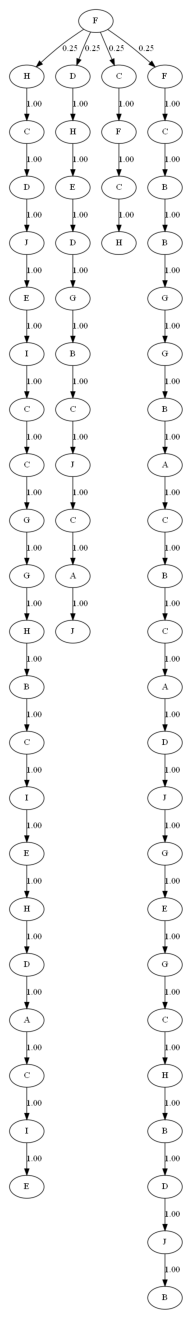

In [48]:
# Probability Tree
sequence_trees = defaultdict(lambda: {'count': 0, 'next': defaultdict(lambda: {'count': 0, 'next': {}})})
for sequence, count in session_aggregate_sequences:
    add_sequence_to_tree(sequence_trees, sequence, count)
calculate_probabilities(sequence_trees)

for key in list(sequence_trees.keys()):
    print(f"Action Tree for '{key}' with Branching Probabilities")
    tree_graph = nx.DiGraph()
    build_networkx_tree(tree_graph, sequence_trees, key, is_root=True)

    agraph = nx.nx_agraph.to_agraph(tree_graph)
    # Use pygraphviz to layout the graph with hierarchical structure
    agraph.layout('dot')
    # Draw the hierarchical graph to a file (or show it directly)
    agraph.draw(f'{key}_action_tree_hierarchy.png')

    # Load the image from the file and show it
    img = mpimg.imread(f'{key}_action_tree_hierarchy.png')
    plt.figure(figsize=(48, 24))
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks

    plt.show()

# Tree Differences

In [1]:
from zss import simple_distance, Node

def convert_to_zss_tree(tree, parent_label=None):
    """ Convert the action tree to a format compatible with zss library """
    if parent_label is None:
        root = Node('root')
        for k, v in tree.items():
            root.addkid(convert_to_zss_tree(v['next'], parent_label=k))
        return root
    else:
        node = Node(parent_label)
        for k, v in tree.items():
            node.addkid(convert_to_zss_tree(v['next'], parent_label=k))
        return node

def tree_edit_distance(tree1, tree2):
    """ Calculate the tree edit distance between two trees """
    tree1_zss = convert_to_zss_tree(tree1)
    tree2_zss = convert_to_zss_tree(tree2)
    return simple_distance(tree1_zss, tree2_zss)

def compare_node_path_frequency(tree1, tree2):
    """ Compare node and path frequencies of two trees """
    comparison = {}

    def traverse(node1, node2, path=()):
        if node1 is None or node2 is None:
            return
        for action in node1:
            new_path = path + (action,)
            count1 = node1[action]['count']
            count2 = node2.get(action, {}).get('count', 0)
            comparison[new_path] = (count1, count2)
            traverse(node1[action]['next'], node2.get(action, {}).get('next', {}), new_path)

    traverse(tree1, tree2)
    return comparison

def structural_comparison(tree1, tree2):
    """ Compare the structure of two trees """
    def tree_stats(tree):
        depths = []
        branching_factors = []
        
        def traverse(node, depth=0):
            if not node:
                depths.append(depth)
                return
            branching_factors.append(len(node))
            for action in node:
                traverse(node[action]['next'], depth + 1)

        traverse(tree)
        return max(depths), sum(branching_factors) / len(branching_factors)

    depth1, branching_factor1 = tree_stats(tree1)
    depth2, branching_factor2 = tree_stats(tree2)

    return {
        'max_depth': (depth1, depth2),
        'avg_branching_factor': (branching_factor1, branching_factor2)
    }

def visualize_trees_side_by_side(tree1, tree2, start_action1, start_action2):
    """ Visualize two trees side by side for comparison """
    tree_graph1 = nx.DiGraph()
    build_networkx_tree(tree_graph1, tree1, start_action1, is_root=True)

    tree_graph2 = nx.DiGraph()
    build_networkx_tree(tree_graph2, tree2, start_action2, is_root=True)

    plt.figure(figsize=(48, 24))

    plt.subplot(1, 2, 1)
    pos = nx.kamada_kawai_layout(tree_graph1)
    nx.draw(tree_graph1, pos, with_labels=True, labels=nx.get_node_attributes(tree_graph1, 'label'),
            node_color='lightblue', node_size=2000, edge_color='gray', linewidths=2, font_size=15)
    plt.title(f"Tree 1: '{start_action1}'")

    plt.subplot(1, 2, 2)
    pos = nx.kamada_kawai_layout(tree_graph2)
    nx.draw(tree_graph2, pos, with_labels=True, labels=nx.get_node_attributes(tree_graph2, 'label'),
            node_color='lightgreen', node_size=2000, edge_color='gray', linewidths=2, font_size=15)
    plt.title(f"Tree 2: '{start_action2}'")

    plt.show()



In [10]:
import pandas as pd

def split_dataframe(csv_path, frac=0.5):
    """ Split the DataFrame into two random samples. """
    df = pd.read_csv(csv_path)
    df = df[0:1000]
    sample1 = df.sample(frac=frac, random_state=1)  # Random sample 1
    sample2 = df.drop(sample1.index)                 # Remaining part as sample 2
    return sample1, sample2

# Splitting the action DataFrame
df_sample1, df_sample2 = split_dataframe('df_actions.csv')


In [11]:
df_sample1.head()

,user_id,email,action,timestamp,cohort,cohort_period
507,28,hmoore@example.org,J,2023-10-31 16:14:40.083792,2023-10,0
818,46,garycruz@example.com,I,2023-10-08 16:06:40.095310,2023-10,0
452,26,petermccullough@example.net,H,2023-10-11 15:47:40.082794,2023-10,0
368,22,mnguyen@example.net,C,2023-10-26 15:48:40.079792,2023-10,0
242,12,iellis@example.org,F,2023-11-01 16:08:40.074275,2023-11,0


In [12]:
df_sample1.shape, df_sample2.shape

((500, 6), (500, 6))

## Between Sample Comparison Edit Distance

In [13]:
def compare_dataframes(df_list, df_names):
    """ Compare DataFrames based on their filtered action trees. """
    trees = []

    # Generate action trees for each DataFrame using filtered action sequences
    for df in df_list:
        df_sessionized = sessionize_actions(df)
        df_session_sequences = df_sessionized.groupby(['user_id', 'session_id'])['action'].apply(list).reset_index()
        df_session_sequences['action_sequences'] = df_session_sequences['action'].apply(generate_unique_sequences)
        df_session_sequences['filtered_action_sequences'] = df_session_sequences['action_sequences'].apply(filter_subsequences)

        tree = defaultdict(lambda: {'count': 0, 'next': defaultdict(lambda: {'count': 0, 'next': {}})})
        for _, row in df_session_sequences.iterrows():
            sequence_counter = row['filtered_action_sequences']
            for seq, cnt in sequence_counter.items():
                add_sequence_to_tree(tree, seq, cnt)
        calculate_probabilities(tree)
        trees.append(tree)

    # Comparing the trees
    for i in range(len(trees)):
        for j in range(i + 1, len(trees)):
            print(f"Comparing {df_names[i]} with {df_names[j]}:")

            # Tree Edit Distance
            distance = tree_edit_distance(trees[i], trees[j])
            print(f"  Tree Edit Distance: {distance}")

            # Node and Path Frequency Comparison
            frequency_comparison = compare_node_path_frequency(trees[i], trees[j])
            print(f"  Frequency Comparison: {frequency_comparison}")

            # Structural Comparison
            structural_stats = structural_comparison(trees[i], trees[j])
            print(f"  Structural Comparison: {structural_stats}")

# Assuming df_sample1 and df_sample2 are defined
compare_dataframes([df_sample1, df_sample2], ['Sample1', 'Sample2'])


Comparing Sample1 with Sample2:
  Tree Edit Distance: 437.0
  Frequency Comparison: {('B',): (4, 10), ('B', 'G'): (1, 1), ('B', 'G', 'C'): (1, 0), ('B', 'G', 'C', 'E'): (1, 0), ('B', 'G', 'C', 'E', 'F'): (1, 0), ('B', 'G', 'C', 'E', 'F', 'I'): (1, 0), ('B', 'G', 'C', 'E', 'F', 'I', 'J'): (1, 0), ('B', 'G', 'C', 'E', 'F', 'I', 'J', 'I'): (1, 0), ('B', 'G', 'C', 'E', 'F', 'I', 'J', 'I', 'I'): (1, 0), ('B', 'G', 'C', 'E', 'F', 'I', 'J', 'I', 'I', 'I'): (1, 0), ('B', 'B'): (1, 1), ('B', 'B', 'J'): (1, 0), ('B', 'B', 'J', 'E'): (1, 0), ('B', 'B', 'J', 'E', 'D'): (1, 0), ('B', 'A'): (1, 1), ('B', 'A', 'F'): (1, 0), ('B', 'A', 'F', 'J'): (1, 0), ('B', 'C'): (1, 0), ('B', 'C', 'F'): (1, 0), ('B', 'C', 'F', 'H'): (1, 0), ('B', 'C', 'F', 'H', 'J'): (1, 0), ('B', 'C', 'F', 'H', 'J', 'B'): (1, 0), ('B', 'C', 'F', 'H', 'J', 'B', 'H'): (1, 0), ('B', 'C', 'F', 'H', 'J', 'B', 'H', 'J'): (1, 0), ('B', 'C', 'F', 'H', 'J', 'B', 'H', 'J', 'H'): (1, 0), ('B', 'C', 'F', 'H', 'J', 'B', 'H', 'J', 'H', 'I'): (

## Starting Action Compare Sequences

In [49]:
def generate_trees_for_starting_actions(df):
    """ Generate action trees for each unique starting action in a DataFrame. """
    df_sessionized = sessionize_actions(df)
    df_session_sequences = df_sessionized.groupby(['user_id', 'session_id'])['action'].apply(list).reset_index()

    starting_action_trees = {}
    for _, row in df_session_sequences.iterrows():
        if row['action']:
            starting_action = row['action'][0]
            sequence_counter = generate_unique_sequences(row['action'])
            
            if starting_action not in starting_action_trees:
                starting_action_trees[starting_action] = defaultdict(lambda: {'count': 0, 'next': defaultdict(lambda: {'count': 0, 'next': {}})})
            
            for seq, cnt in sequence_counter.items():
                add_sequence_to_tree(starting_action_trees[starting_action], seq, cnt)
    
    # Calculate probabilities for each tree
    for tree in starting_action_trees.values():
        calculate_probabilities(tree)

    return starting_action_trees


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
def compare_trees_within_dataframe(df, df_name):
    """ Compare trees of different starting actions within a single DataFrame and visualize the results. """
    trees = generate_trees_for_starting_actions(df)
    starting_actions = list(trees.keys())

    # Initialize matrices for storing comparison results
    n = len(starting_actions)
    distance_matrix = np.zeros((n, n))
    depth_matrix = np.zeros((n, n))
    branching_factor_matrix = np.zeros((n, n))

    for i in tqdm(range(n), desc=f"Comparing trees in {df_name}", total=n):
        for j in range(i + 1, n):
            # Tree Edit Distance
            distance = tree_edit_distance(trees[starting_actions[i]], trees[starting_actions[j]])
            distance_matrix[i, j] = distance_matrix[j, i] = distance

            # Structural Comparison
            structural_stats = structural_comparison(trees[starting_actions[i]], trees[starting_actions[j]])
            depth_diff = abs(structural_stats['max_depth'][0] - structural_stats['max_depth'][1])
            branching_factor_diff = abs(structural_stats['avg_branching_factor'][0] - structural_stats['avg_branching_factor'][1])

            depth_matrix[i, j] = depth_matrix[j, i] = depth_diff
            branching_factor_matrix[i, j] = branching_factor_matrix[j, i] = branching_factor_diff

    # Visualizing the heatmaps
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Heatmap for Tree Edit Distance
    sns.heatmap(distance_matrix, annot=True, fmt=".2f", ax=ax[0], xticklabels=starting_actions, yticklabels=starting_actions)
    ax[0].set_title("Tree Edit Distance Heatmap")
    ax[0].set_xlabel("Starting Actions")
    ax[0].set_ylabel("Starting Actions")

    # Heatmap for Depth Difference
    sns.heatmap(depth_matrix, annot=True, fmt=".2f", ax=ax[1], xticklabels=starting_actions, yticklabels=starting_actions)
    ax[1].set_title("Depth Difference Heatmap")

    # Heatmap for Branching Factor Difference
    sns.heatmap(branching_factor_matrix, annot=True, fmt=".2f", ax=ax[2], xticklabels=starting_actions, yticklabels=starting_actions)
    ax[2].set_title("Branching Factor Difference Heatmap")

    plt.suptitle(f"Action Tree Comparisons for {df_name}")
    plt.tight_layout()
    plt.show()


Comparing trees in Sample1: 100%|██████████| 10/10 [01:43<00:00, 10.32s/it]


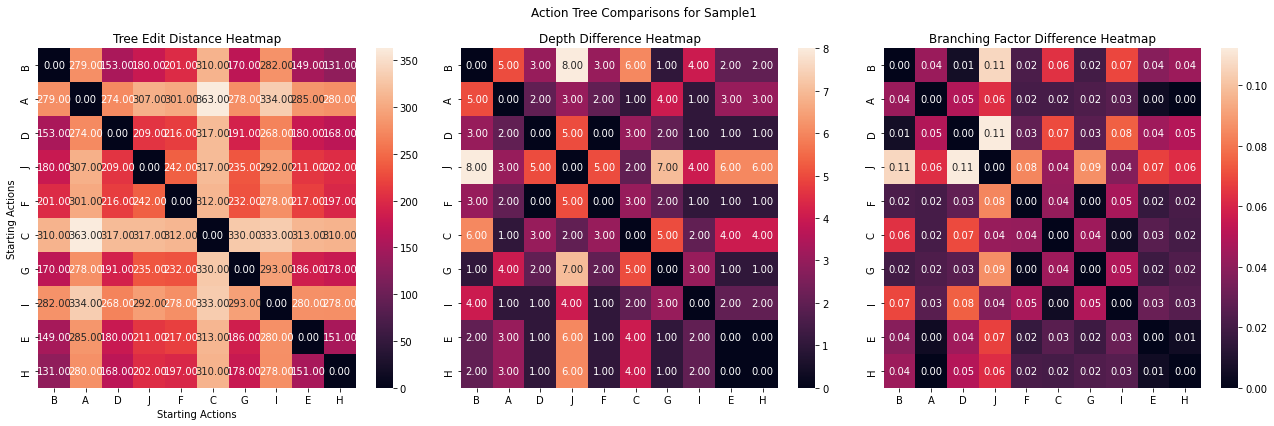

In [36]:
compare_trees_within_dataframe(df_sample1, 'Sample1')


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def compare_trees_within_dataframe(df, df_name):
    """ Compare trees of different starting actions within a single DataFrame and store the results in a DataFrame. """
    trees = generate_trees_for_starting_actions(df)
    starting_actions = list(trees.keys())

    # Create a DataFrame to store the results
    comparison_results = []

    for i, action_i in tqdm(enumerate(starting_actions), total=len(starting_actions)):
        for j, action_j in enumerate(starting_actions):
            if i < j:
                # Tree Edit Distance
                distance = tree_edit_distance(trees[action_i], trees[action_j])

                # Structural Comparison
                structural_stats = structural_comparison(trees[action_i], trees[action_j])
                depth_diff = abs(structural_stats['max_depth'][0] - structural_stats['max_depth'][1])
                branching_factor_diff = abs(structural_stats['avg_branching_factor'][0] - structural_stats['avg_branching_factor'][1])

                # Store the results
                comparison_results.append({
                    'Action1': action_i,
                    'Action2': action_j,
                    'Tree Edit Distance': distance,
                    'Depth Difference': depth_diff,
                    'Branching Factor Difference': branching_factor_diff
                })

    comparison_df = pd.DataFrame(comparison_results)
    return comparison_df

def visualize_comparison_heatmap(comparison_df, metric):
    """ Visualize a heatmap for a given comparison metric. """
    # Create a pivot table for the heatmap
    pivot_df = comparison_df.pivot(index='Action1', columns='Action2', values=metric)

    # Fill diagonal and lower triangle with NaNs since they are redundant or not computed
    for i in range(pivot_df.shape[0]):
        for j in range(pivot_df.shape[1]):
            if i >= j:
                pivot_df.iat[i, j] = np.nan

    sns.heatmap(pivot_df, annot=True, cmap='viridis')
    plt.xticks(rotation=90)
    #figsize
    
    plt.title(f"{metric} Heatmap")
    plt.show()




In [26]:
# Assuming df_sample1 is defined
comparison_df = compare_trees_within_dataframe(df_sample1, 'Sample1')

# You can now visualize or analyze `comparison_df` as needed



100%|██████████| 10/10 [01:52<00:00, 11.29s/it]

  Action1 Action2  Tree Edit Distance  Depth Difference   
0       B       A               279.0                 5  \
1       B       D               153.0                 3   
2       B       J               180.0                 8   
3       B       F               201.0                 3   
4       B       C               310.0                 6   

   Branching Factor Difference  
0                     0.043137  
1                     0.006061  
2                     0.106239  
3                     0.022101  
4                     0.063964  


In [28]:
comparison_df.head()  # Print the first few rows of the DataFrame


,Action1,Action2,Tree Edit Distance,Depth Difference,Branching Factor Difference
0,B,A,279.0,5,0.043137
1,B,D,153.0,3,0.006061
2,B,J,180.0,8,0.106239
3,B,F,201.0,3,0.022101
4,B,C,310.0,6,0.063964


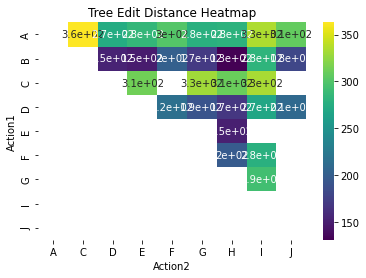

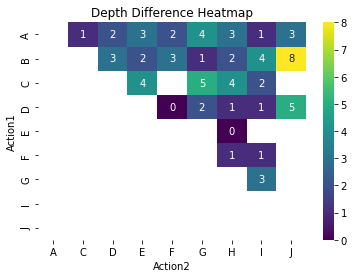

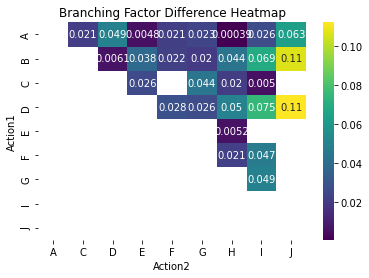

In [31]:
# Visualize Tree Edit Distance Heatmap
visualize_comparison_heatmap(comparison_df, 'Tree Edit Distance')

# Visualize Depth Difference Heatmap
visualize_comparison_heatmap(comparison_df, 'Depth Difference')

# Visualize Branching Factor Difference Heatmap
visualize_comparison_heatmap(comparison_df, 'Branching Factor Difference')

## Between Sample Diff and Chi Square pvalue

In [41]:
def aggregate_group_data(dataframes):
    """
    Aggregate data from multiple DataFrames and generate action sequences.
    """
    aggregated_df = pd.concat(dataframes)
    aggregated_df_sorted = aggregated_df.sort_values(by=['user_id', 'timestamp'])
    df_sequences = aggregated_df_sorted.groupby('user_id')['action'].apply(list).reset_index()
    df_sequences['filtered_action_sequences'] = df_sequences['action'].apply(generate_unique_sequences).apply(filter_subsequences)
    
    return df_sequences

def compare_trees(tree1, tree2):
    """
    Compare two trees based on frequency of nodes.
    Returns a dictionary of differences.
    """
    differences = {}
    for action in set(tree1.keys()).union(tree2.keys()):
        count1 = tree1.get(action, {'count': 0})['count']
        count2 = tree2.get(action, {'count': 0})['count']
        if count1 != count2:
            differences[action] = (count1, count2)
    
    return differences
from scipy.stats import chi2_contingency

def perform_chi_square_test(tree1, tree2):
    """
    Perform a Chi-Square test to see if the distribution of actions is significantly different.
    """
    data = []
    for action in set(tree1.keys()).union(tree2.keys()):
        count1 = tree1.get(action, {'count': 0})['count']
        count2 = tree2.get(action, {'count': 0})['count']
        data.append([count1, count2])
    
    chi2, p, dof, ex = chi2_contingency(data)
    return {'chi2_statistic': chi2, 'p_value': p}


In [42]:

# Creating two sample dataframes for two groups
df_group1 = df_sample1
df_group2 = df_sample2

# List of dataframes and their names
df_list = [df_group1, df_group2]
df_names = ['Group 1', 'Group 2']
# Assuming the previously defined functions are in place

# Aggregate data for each group
group1_sequences = aggregate_group_data([df_list[0]])  # for Group 1
group2_sequences = aggregate_group_data([df_list[1]])  # for Group 2

# Create trees for each group
tree1 = defaultdict(lambda: {'count': 0, 'next': defaultdict(lambda: {'count': 0, 'next': {}})})
tree2 = defaultdict(lambda: {'count': 0, 'next': defaultdict(lambda: {'count': 0, 'next': {}})})

for _, row in group1_sequences.iterrows():
    for sequence, count in row['filtered_action_sequences'].items():
        add_sequence_to_tree(tree1, sequence, count)
calculate_probabilities(tree1)

for _, row in group2_sequences.iterrows():
    for sequence, count in row['filtered_action_sequences'].items():
        add_sequence_to_tree(tree2, sequence, count)
calculate_probabilities(tree2)

# Compare trees and perform statistical analysis
differences = compare_trees(tree1, tree2)
chi_square_result = perform_chi_square_test(tree1, tree2)

# Print results
print("Differences between trees:", differences)
print("Chi-Square Test Results:", chi_square_result)


Differences between trees: {'I': (6, 9), 'H': (5, 10), 'F': (8, 3), 'E': (5, 4), 'D': (6, 4), 'B': (4, 8), 'C': (9, 7), 'A': (8, 5)}
Chi-Square Test Results: {'chi2_statistic': 7.318259504541284, 'p_value': 0.6040213311832721}
